In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [11]:
def random_uniform_disk(n, radius=1.0):
    theta = np.random.uniform(low=0.0, high=2*np.pi, size=n)
    r = np.sqrt(np.random.uniform(low=0.0, high=radius**2, size=n))
    x, y = r * np.cos(theta), r * np.sin(theta)
    return np.column_stack((x, y))

def random_uniform_ellipse(n, M=np.eye(2)):
    return random_uniform_disk(n) @ M

In [307]:
N = 5000
M = np.array([[0.9, -0.2], [-0.2, 0.9]])
p = random_uniform_ellipse(N, M=M)

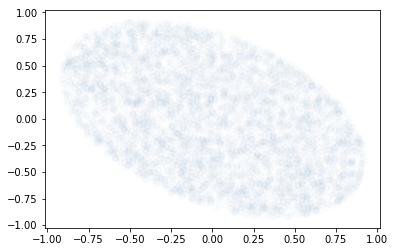

In [308]:
plt.scatter(p[:, 0], p[:, 1], alpha=0.01)

In [309]:
def line_segment(x, x0, y0, x1, y1):
    m = (y1 - y0) / (x1 - x0)
    return m * (x - x0) + y0

In [310]:
def compute_time_of_day_factor(t):
    cond_list = [
        (t >= 6.0) & (t <= 8.0),
        (t >= 8.0) & (t <= 10.0),
        (t >= 10.0) & (t <= 16.0),
        (t >= 16.0) & (t <= 18.0),
        (t >= 18.0) & (t <= 21.0)
    ]
    choice_list = [
        line_segment(t, 6.0, 0.5, 8.0, 2.0),
        line_segment(t, 8.0, 2.0, 10.0, 0.75),
        0.75,
        line_segment(t, 16.0, 0.75, 18.0, 2.0),
        line_segment(t, 18.0, 2.0, 21.0, 0.5)
    ]
    return np.select(cond_list, choice_list, default=0.5)

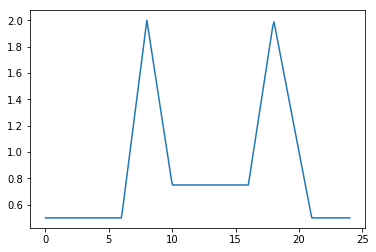

In [311]:
t = np.linspace(0.0, 24.0, num=250)
plt.plot(t, compute_time_of_day_factor(t))

In [312]:
def sample_time_of_day(n):
    # Dead-of-night, daytime commute, mid-day, evening commute
    p_commute_type = [0.05, 0.35, 0.25, 0.35]
    dead_of_night_samples = np.random.uniform(21.0, 30.0, size=n) % 24.0
    daytime_commute_samples = np.random.triangular(
        left=6.0, mode=8.0, right=11.0, size=n)
    midday_samples = np.random.uniform(10.0, 16.0, size=n)
    evening_commute_samples = np.random.triangular(
        left=15.0, mode=18.0, right=22.0, size=n)
    return np.choose(
        np.random.choice(4, size=n, p=p_commute_type),
        [
            dead_of_night_samples,
            daytime_commute_samples,
            midday_samples,
            evening_commute_samples
        ]
    )

In [313]:
tods = sample_time_of_day(5000)

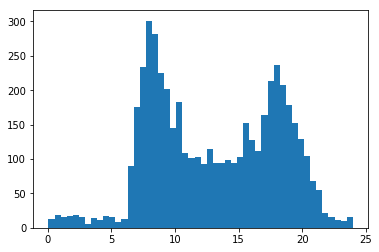

In [314]:
_ = plt.hist(tods, bins=50)

In [315]:
def sample_gamma(n, mode=1.0, shape=5.0):
    scale = mode / (shape - 1)
    return np.random.gamma(shape=shape, scale=scale, size=n)

In [316]:
def compute_commute_time(sources, targets, time_of_day):
    assert sources.shape == targets.shape
    assert sources.shape[1] == 2
    assert time_of_day.shape[0] == sources.shape[0]
    N = sources.shape[0]
    raw_distance = compute_raw_distance(sources, targets)
    # Scale is chosen so that the mode of the conjestion_factor is one.
    conjestion_factor = np.maximum(
        sample_gamma(n=N, mode=1.0, shape=5.0), 1.0)
    geometry_factor = compute_geometry_factor(sources, targets)
    time_of_day_factor = compute_time_of_day_factor(time_of_day)
    return (
        conjestion_factor 
            * geometry_factor 
            * time_of_day_factor 
            * raw_distance)

def compute_raw_distance(sources, targets):
    raw_distance = (
        np.abs(sources[:, 0] - targets[:, 0]) +
        np.abs(sources[:, 1] - targets[:, 1]))
    return raw_distance

def compute_geometry_factor(sources, targets):
    N = sources.shape[0]
    first_to_fourth_quad_factor = np.maximum(
        sample_gamma(n=N, mode=5.0, shape=10.0), 1.0)
    first_or_fourth_to_bottom_half_factor = np.maximum(
        sample_gamma(n=N, mode=2.0, shape=5.0), 1.0)
    cond_list = [
        in_first_quad(sources) & in_fourth_quad(targets),
        in_fourth_quad(sources) & in_first_quad(targets),
        (in_first_quad(sources) | in_fourth_quad(sources)) 
            & in_lower_half_plane(targets),
        (in_first_quad(targets) | in_fourth_quad(targets)) 
            & in_lower_half_plane(sources),
    ]
    choice_list = [
        first_to_fourth_quad_factor,
        first_to_fourth_quad_factor,
        first_or_fourth_to_bottom_half_factor,
        first_or_fourth_to_bottom_half_factor
    ]
    return np.maximum(
        np.select(cond_list, choice_list, default=1.0), 1.0)
                                      
def in_first_quad(xy):
    return (xy[:, 0] >= 0) & (xy[:, 1] >= 0)

def in_fourth_quad(xy):
    return (xy[:, 0] <= 0) & (xy[:, 1] >= 0)

def in_lower_half_plane(xy):
    return xy[:, 1] <= 0

In [331]:
sources = random_uniform_ellipse(N, M=M)
targets = random_uniform_ellipse(N, M=M)
time_of_day = sample_time_of_day(N)
ct = compute_commute_time(sources, targets, time_of_day)

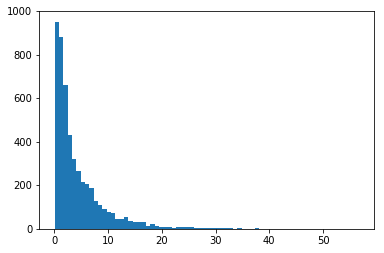

In [332]:
_ = plt.hist(ct, bins=70)

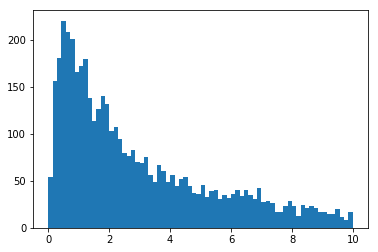

In [333]:
_ = plt.hist(ct[ct < 10], bins=70)

In [334]:
gf = compute_geometry_factor(sources, targets)

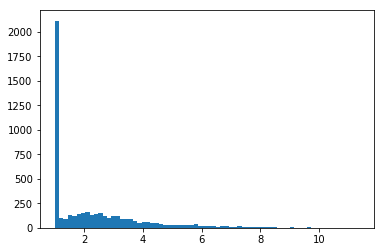

In [335]:
_ = plt.hist(gf, bins=70)

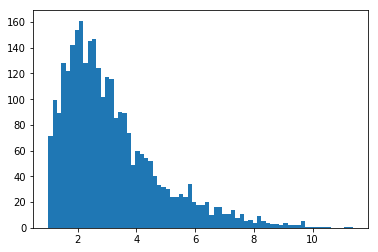

In [336]:
_ = plt.hist(gf[gf > 1.0], bins=70)

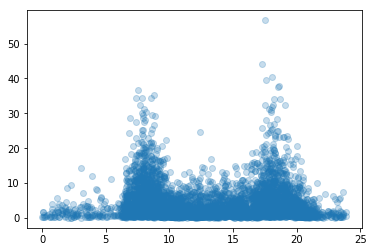

In [340]:
plt.scatter(time_of_day, ct, alpha=0.25)